# Model Tuning
---

### Import Packages

In [29]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import product
import dataframe_image as dfi
import joblib

import warnings

import params as p
import functions as f

from xgboost import XGBRegressor

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

import optuna
from optuna.integration import OptunaSearchCV
from optuna.distributions import IntUniformDistribution, UniformDistribution, LogUniformDistribution, CategoricalDistribution
from optuna.samplers import TPESampler

### Settings

In [2]:
warnings.simplefilter(action='ignore', category = FutureWarning)

### Import Data

In [3]:
# Load train, test and validation datasets
train, test, val = f.load_split_datasets(part = '03')

In [4]:
# Split datasets into X and y components
X_train, y_train = f.split_data_X_y(train)
X_test, y_test = f.split_data_X_y(test)
X_val, y_val = f.split_data_X_y(val)

In [5]:
# Define train/test/validation dictionaries to make fitting and evaluation arguments cleaner
train_data = {'X' : X_train, 'y' : y_train}
test_data = {'X' : X_test, 'y' : y_test}
val_data = {'X' : X_val, 'y' : y_val}

### Create Baseline Model

In [42]:
print('lr model...', end = ' ')
lr = LinearRegression().fit(**train_data)
print('trained')

lr model... trained


In [45]:
joblib.dump(lr, p.OUTPUTS_PATH + 'baseline_model.pkl')

['./outputs/baseline_model.pkl']

### Evaluate Initial Models on Train and Test Data

In [43]:
models = [lr]

rmse_initial_results = {
    'Model' : ['Linear Regresssion (Baseline)'],
    'R2 Train' : [f.evaluate_model(model, metric = 'r2', **train_data) for model in models],
    'R2 Test' : [f.evaluate_model(model, metric = 'r2', **test_data) for model in models]
    }
initial_results = pd.DataFrame(rmse_initial_results)
initial_results[['R2 Train', 'R2 Test']].T

,0
R2 Train,0.567670
R2 Test,0.551524


### Initial Models for xgb/rf

In [8]:
base_params = {
    'n_jobs' : -1,
    'random_state' : p.RANDOM_STATE,
    }

In [9]:
xgb_optuna_base = XGBRegressor(**base_params)

In [10]:
rf_optuna_base = RandomForestRegressor(**base_params)

In [11]:
models = [lr, xgb_optuna_base, rf_optuna_base]

rmse_initial_results = {
    'Model' : ['Linear Regresssion (Baseline)', 'Initial XGBoost', 'Initial Random Forest'],
    'R2 Train' : [f.evaluate_model(model.fit(**train_data), metric = 'r2', **train_data) for model in models],
    'R2 Test' : [f.evaluate_model(model.fit(**train_data), metric = 'r2', **test_data) for model in models]
    }
initial_results = pd.DataFrame(rmse_initial_results)
initial_results

,Model,R2 Train,R2 Test
0,Linear Regresssion (Baseline),0.567670,0.551524
1,Initial XGBoost,0.986061,0.910505
2,Initial Random Forest,0.983250,0.883622


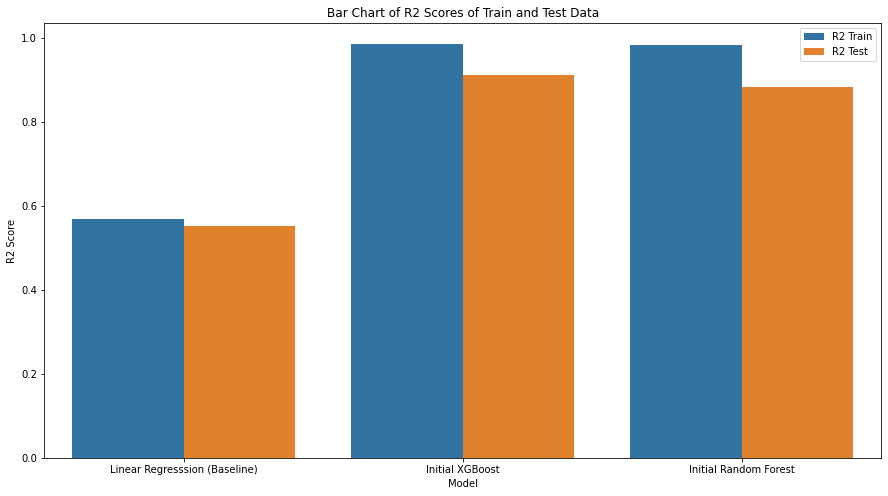

In [12]:
fig, ax = plt.subplots(1, 1, figsize = (15, 8))

melt_data = initial_results.melt(id_vars = 'Model')

sns.barplot(
    ax = ax,
    data = melt_data,
    x = 'Model',
    y = 'value',
    hue = 'variable').set(title = 'Bar Chart of R2 Scores of Train and Test Data')

plt.ylabel('R2 Score')
plt.legend()
plt.savefig(p.OUTPUTS_PATH + 'initial_models.png')
plt.show()

1. The Linear Regression model does show a reasonable performance and, since we cannot tune it, will provide a good baseline to compare our initial results against.

1. We can see that the XGBoost model does seem to have the best performance currently with R2 scores of 0.986061 and 0.910505 from train and test respectively. However, the RandomForest model does show similar R2, albeit slightly lower. Since these are the two models that are more open to extensive tuning, initial results show that the most appropriate model will be one of these. Comparing these models to our baseline, we can see that we have already got more value out changing the model before tuning.

### Model Tuning - Optuna

We will be using the optuna framework to train our models due to the improved performance on sklearn's `RandomizedSearchCV` and the nice structure optuna brings.

1. We start with the XGBoost tuning, breaking it down into three sections: Tree-based parameters, Regularization Parameters and Learning Rate. We will use a separate optuna study for each section to effectively tune the model and avoid over fitting. Tree-based parameters include `max_depth`, `min_child_weight`, `n_estimators`, `subsample`, `gamma` and `colsample_by_tree`; Regularization parameters include `alpha` and `lambda` to focus on over fitting control; and the final section just looks at finding the optimal `learning_rate` based on the other optimal parameters.

1. Since all the RandomForest parameters fall into the same category, we can use a single optuna study to tune this model. The parameters that we will be tuning are the following: `max_depth`, `max_features`, `n_estimators`, `bootstrap`, `min_samples_leaf` and `min_samples_split`.

1. The final model to tune is the Naive Bayes model which only requires tuning of `var_smoothing` which helps control over fitting.

In [13]:
sampler = TPESampler(seed = p.RANDOM_STATE)

### XGB Tuning

In [14]:
# xgb_optuna_base = XGBRegressor(**base_params, max_depth = 3, learning_rate = 0.01)
xgb_optuna_base = XGBRegressor(**base_params)

In [15]:
xgb_oscv_params = {
    'max_depth' : CategoricalDistribution([2,3,4,5]),
    'learning_rate' : CategoricalDistribution([0.01, 0.03, 0.1, 0.3]),
    'min_child_weight' : IntUniformDistribution(5, 10),
    'n_estimators' : IntUniformDistribution(50, 1000),
    'subsample' : UniformDistribution(0.1, 1),
    'gamma' : LogUniformDistribution(1e-2, 10.0),
    'colsample_bytree' : UniformDistribution(0.1, 1),
    'reg_lambda' : LogUniformDistribution(1e-2, 10.0),
    'reg_alpha' : LogUniformDistribution(1e-2, 10.0)
    }

xgb_study = optuna.create_study(sampler = sampler, direction = 'maximize', study_name = 'XGB_HyperParam_CV')

xgb_oscv = OptunaSearchCV(
    study = xgb_study,
    estimator = xgb_optuna_base,
    param_distributions = xgb_oscv_params,
    cv = 10,
    n_jobs = -1,
    n_trials = 200,
    random_state = p.RANDOM_STATE,
    refit = True,
    scoring = 'r2',
    verbose = 1,
)

xgb_oscv.fit(X_train, y_train, verbose = 0)

[I 2022-04-17 12:24:29,946] A new study created in memory with name: XGB_HyperParam_CV
/var/folders/2f/cwgmhyzx4fn5cwp5j_dpmsd00000gn/T/ipykernel_82761/4286368788.py:15: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  xgb_oscv = OptunaSearchCV(
[I 2022-04-17 12:24:29,955] Searching the best hyperparameters using 5083 samples...
[I 2022-04-17 12:33:56,917] Trial 0 finished with value: 0.47727483354604894 and parameters: {'max_depth': 5, 'learning_rate': 0.03, 'min_child_weight': 9, 'n_estimators': 67, 'subsample': 0.28597737602408035, 'gamma': 8.032007880256426, 'colsample_bytree': 0.18296714499432493, 'reg_lambda': 0.6800649514156517, 'reg_alpha': 0.03540807447183764}. Best is trial 0 with value: 0.47727483354604894.
[I 2022-04-17 12:42:19,288] Trial 5 finished with value: 0.7955679655932874 and parameters: {'max_depth': 2, 'learning_rate': 0.03, 'min_child_weight': 9, 'n_estimators': 287, 'subsample': 0.1928187883

OptunaSearchCV(cv=10,
               estimator=XGBRegressor(base_score=None, booster=None,
                                      colsample_bylevel=None,
                                      colsample_bynode=None,
                                      colsample_bytree=None,
                                      enable_categorical=False, gamma=None,
                                      gpu_id=None, importance_type=None,
                                      interaction_constraints=None,
                                      learning_rate=None, max_delta_step=None,
                                      max_depth=None, min_child_weight=None,
                                      missing=nan, monotone_constraints=Non...
                                    'min_child_weight': IntUniformDistribution(high=10, low=5, step=1),
                                    'n_estimators': IntUniformDistribution(high=1000, low=50, step=1),
                                    'reg_alpha': LogUniformDistrib

In [16]:
def make_optuna_visualizations(study: optuna.Study): 

    fig = optuna.visualization.plot_optimization_history(study)
    fig.show()

    fig = optuna.visualization.plot_param_importances(study)
    fig.show()

    fig = optuna.visualization.plot_slice(study)
    fig.show()

make_optuna_visualizations(xgb_study)

In [23]:
xgb_tuned = xgb_oscv.best_estimator_

In [24]:
model = xgb_tuned

train_r2 = f.evaluate_model(model, metric = 'r2', **train_data)
test_r2 = f.evaluate_model(model, metric = 'r2', **test_data)

print('Train R2:', train_r2)
print('Test R2:', test_r2)

Train R2: 0.987649
Test R2: 0.908359


a little overfit so will do some manual adjustments

### Manual Hyperparameter Adjustments

In [41]:
oscv_params = xgb_oscv.best_params_

max_depth_params  = [2,3,4,5,6]
learning_rate_params = [0.01, 0.03, 0.1]

param_perms = product(max_depth_params, learning_rate_params)

results_record = {
    'max_depth' : [],
    'learning_rate' : [],
    'Train R2 Score' : [],
    'Test R2 Score' : []}

for md, learnr in param_perms:

    model_params = {
        **base_params,
        **oscv_params,
        'max_depth' : md,
        'learning_rate' : learnr
        }


    fn_model = XGBRegressor(**model_params).fit(**train_data)

    train_r2 = f.evaluate_model(fn_model, metric = 'r2', **train_data)
    test_r2 = f.evaluate_model(fn_model, metric = 'r2', **test_data)

    results_record['max_depth'].append(md)
    results_record['learning_rate'].append(learnr)
    results_record['Train R2 Score'].append(train_r2)
    results_record['Test R2 Score'].append(test_r2)

pd_results_record = pd.DataFrame(results_record)

pd_results_record['Difference'] = pd_results_record['Train R2 Score'] - pd_results_record['Test R2 Score']

pd_results_record_out = pd_results_record.nsmallest(8, 'Difference').set_index(['max_depth', 'learning_rate'])

pd_results_record_out

Train R2 Score  Test R2 Score  Difference
max_depth learning_rate                                           
2         0.01                 0.787679       0.767657    0.020022
          0.03                 0.853452       0.832502    0.020950
3         0.01                 0.853665       0.832012    0.021653
4         0.01                 0.890772       0.865678    0.025094
3         0.03                 0.899845       0.872024    0.027821
5         0.01                 0.917122       0.886529    0.030593
2         0.10                 0.890250       0.855470    0.034780
4         0.03                 0.931508       0.892944    0.038564

In [28]:
dfi.export(pd_results_record_out, p.OUTPUTS_PATH + 'tweaking_df.png')

objc[88356]: Class WebSwapCGLLayer is implemented in both /System/Library/Frameworks/WebKit.framework/Versions/A/Frameworks/WebCore.framework/Versions/A/Frameworks/libANGLE-shared.dylib (0x7ffa4ca86318) and /Applications/Google Chrome.app/Contents/Frameworks/Google Chrome Framework.framework/Versions/100.0.4896.88/Libraries/libGLESv2.dylib (0x10ffaff48). One of the two will be used. Which one is undefined.
[0418/094704.904119:INFO:headless_shell.cc(659)] Written to file /var/folders/2f/cwgmhyzx4fn5cwp5j_dpmsd00000gn/T/tmpdt_s1vkl/temp.png.


In [19]:
xgb_final_params = {**base_params, **oscv_params}
xgb_final_params['max_depth'] = 4
xgb_final_params['learning_rate'] = 0.01
final_xgb_tuned = XGBRegressor(**xgb_final_params).fit(**train_data)

#### Optuna-Tuned XGB Model

In [30]:
model = final_xgb_tuned

train_r2 = f.evaluate_model(model, metric = 'r2', **train_data)
test_r2 = f.evaluate_model(model, metric = 'r2', **test_data)

print('Train R2:', train_r2)
print('Test R2:', test_r2)

Train R2: 0.890772
Test R2: 0.865678


In [31]:
joblib.dump(final_xgb_tuned, p.OUTPUTS_PATH + 'final_xgb_model.pkl')

['./outputs/final_xgb_model.pkl']

### RandomForest Model Tuning

As mentioned, since the RandomForest hyperparameters are tree-based, we can tune them all with a single study. The parameters we will be tuning are the following: `max_depth`, `max_features`, `n_estimators`, `bootstrap`, `min_samples_leaf` and `min_samples_split`.

In [32]:
model = rf_optuna_base.fit(**train_data)

train_r2 = f.evaluate_model(model, metric = 'r2', **train_data)
test_r2 = f.evaluate_model(model, metric = 'r2', **test_data)


print('Train R2:', train_r2)
print('Test R2:', test_r2)

Train R2: 0.98325
Test R2: 0.883622


In [33]:
rf_oscv_params = {
    'max_depth' : IntUniformDistribution(6, 15),
    'max_features' : CategoricalDistribution(['auto', 'sqrt', 'log2']),
    'n_estimators' : IntUniformDistribution(50, 1000),
    'bootstrap' : CategoricalDistribution([True, False]),
    'min_samples_leaf' : UniformDistribution(0, 0.5),
    'min_samples_split' : UniformDistribution(0, 0.5),
    }

rf_study = optuna.create_study(sampler = sampler, direction = 'maximize', study_name = 'RF_HyperParam_CV')

rf_oscv = OptunaSearchCV(
    study = rf_study,
    estimator = rf_optuna_base,
    param_distributions = rf_oscv_params,
    cv = 10,
    n_jobs = -1,
    n_trials = 200,
    random_state = p.RANDOM_STATE,
    refit = True,
    scoring = 'r2',
    verbose = 1
)

rf_oscv.fit(X_train, y_train)

[I 2022-04-18 09:49:25,115] A new study created in memory with name: RF_HyperParam_CV
/var/folders/2f/cwgmhyzx4fn5cwp5j_dpmsd00000gn/T/ipykernel_82761/548707989.py:12: ExperimentalWarning:

OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.

[I 2022-04-18 09:49:25,148] Searching the best hyperparameters using 5083 samples...
[I 2022-04-18 09:49:46,443] Trial 1 finished with value: -0.001350677712977566 and parameters: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 153, 'bootstrap': True, 'min_samples_leaf': 0.4909921182468571, 'min_samples_split': 0.3183033220201854}. Best is trial 1 with value: -0.001350677712977566.
[I 2022-04-18 09:49:46,978] Trial 2 finished with value: 0.5590920430451592 and parameters: {'max_depth': 12, 'max_features': 'auto', 'n_estimators': 187, 'bootstrap': False, 'min_samples_leaf': 0.06343109689991772, 'min_samples_split': 0.23633070744623347}. Best is trial 2 with value: 0.5590920430451592.
[I 2022-04

OptunaSearchCV(cv=10,
               estimator=RandomForestRegressor(n_jobs=-1, random_state=73),
               n_jobs=-1, n_trials=200,
               param_distributions={'bootstrap': CategoricalDistribution(choices=(True, False)),
                                    'max_depth': IntUniformDistribution(high=15, low=6, step=1),
                                    'max_features': CategoricalDistribution(choices=('auto', 'sqrt', 'log2')),
                                    'min_samples_leaf': UniformDistribution(high=0.5, low=0.0),
                                    'min_samples_split': UniformDistribution(high=0.5, low=0.0),
                                    'n_estimators': IntUniformDistribution(high=1000, low=50, step=1)},
               random_state=73, scoring='r2',
               study=<optuna.study.study.Study object at 0x173b18d90>,
               verbose=1)

In [ ]:
make_optuna_visualizations(rf_study)

In [38]:
rf_tuned = rf_oscv.best_estimator_

In [39]:
print('Train R2:', f.evaluate_model(rf_tuned, metric = 'r2', **train_data))
print('Test R2:', f.evaluate_model(rf_tuned, metric = 'r2', **test_data))

Train R2: 0.849384
Test R2: 0.806394


In [44]:
joblib.dump(rf_tuned, p.OUTPUTS_PATH + 'rf_model.pkl')

['./outputs/rf_model.pkl']

R2 scores of 0.797747 and 0.756056 on our train and test data respectively. This is a substantial change to our initial RandomForest model; however, we have eliminated the massive over fitting that was being performed at the initial modelling stage. We will look at how our model performs on our validation data and compare it to other models.